In [9]:
import numpy as np

In [1]:
import wandb
import os
import pickle


def get_history(user="kealexanderwang", project="constrained-pnns", query={},
                **kwargs):
    api = wandb.Api()
    runs = api.runs(path=f"{user}/{project}", filters=query)
    dataframes = [run.history(**kwargs) for run in runs]
    return list(zip(runs, dataframes))


def download_files(user="kealexanderwang", project="constrained-pnns",
                   query={}, save_dir=".", **kwargs):
    """
    Download the files of each run into a new directory for the run.
    Also saves the config dict of the run.
    """
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)

    api = wandb.Api()
    runs = api.runs(path=f"{user}/{project}", filters=query)
    for run in runs:
        name = run.name
        config = run.config

        run_dir = os.path.join(save_dir, name)
        if not os.path.isdir(run_dir):
            os.mkdir(run_dir)

        with open(os.path.join(run_dir, "config.pkl"), "wb") as h:
            pickle.dump(config, h)

        files = run.files()
        for file in files:
            file.download(root=run_dir)
    return

In [2]:
from pytorch_lightning import Trainer
from pl_trainer import DynamicsModel, SaveTestLogCallback
import os
import pprint 

def load_model_from_run(run, save_dir="/tmp"):
    name = run.display_name
    ckpt_save_path = os.path.join(save_dir, name)
    if not os.path.exists(ckpt_save_path):
        os.makedirs(ckpt_save_path)
     
    ckpts = sorted([f for f in run.files() if "checkpoints" in f.name])
    if len(ckpts) == 0:
        raise RuntimeError(f"Run {name} has no checkpoints!")
    # pick latest checkpoint if available
    last_ckpt = ckpts[-1]
    last_ckpt.download(replace=True, root=ckpt_save_path)
        
    ckpt_path = os.path.join(ckpt_save_path, last_ckpt.name)
    # Uncommet if you need the trainer
    # trainer = Trainer(resume_from_checkpoint=ckpt_path,logger=False)
    pl_trainer = None
    pl_model = DynamicsModel.load_from_checkpoint(ckpt_path)

    pp = pprint.PrettyPrinter(indent=4)
    print("Model Hyperparameters:")
    pp.pprint(vars(pl_model.hparams))
    return pl_trainer, pl_model

/home/marc/anaconda3/envs/default/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/marc/anaconda3/envs/default/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/marc/anaconda3/envs/default/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/marc/anaconda3/envs/de

In [3]:
# See https://docs.wandb.com/library/reference/wandb_api for how to write queries
query = {"tags": {"$eq": "3pendulum"}}
runs, histories = zip(*get_history(query=query))
pl_trainer, pl_model = load_model_from_run(runs[1])

wandb: ERROR Not authenticated.  Copy a key from https://app.wandb.ai/authorize


API Key: ········


wandb: Appending key for api.wandb.ai to your netrc file: /home/marc/.netrc
/home/marc/anaconda3/envs/default/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'pl_trainer.DynamicsModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


100
200
300
400
500
600
700
800
900
1000
CH ignores angular_dims
CH currently assumes potential energy depends only on q
CH currently assumes time independent Hamiltonian
CH assumes positions q are in Cartesian coordinates
Model Hyperparameters:
{   'angular_dims': range(0, 3),
    'batch_size': 800,
    'body_args': [3],
    'body_class': 'ChainPendulum',
    'callbacks': [   <pytorch_lightning.callbacks.lr_logger.LearningRateLogger object at 0x7f2e750a1f90>,
    'check_val_every_n_epoch': 10,
    'chunk_len': 5,
    'ckpt_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn3m1l1/CLNN/wandb/run-20200506_050956-d5so9hyq/constrained-pnns/version_d5so9hyq/checkpoints',
    'dataset_class': 'RigidBodyDataset',
    'debug': False,
    'dof_ndim': 2,
    'dt': 0.1,
    'euclidean': True,
    'exp_dir': '/home/alex_w/repos/hamiltonian-biases/experiments/ChainPendulumn3m1l1/CLNN',
    'fast_dev_run': False,
    'gpus': 1,
    'hidden_size': 200,
    'integration_time': 10.0

In [34]:
pl_model.model = pl_model.model.cuda().float()
for mb in pl_model.test_dataloader():
    z0, T = mb[0]  # assume timesteps evenly spaced for now
    z0 = z0.cuda().float()
    break
results = pl_model.compare_rollouts(z0,pl_model.hparams.integration_time,pl_model.hparams.dt,1e-5)

In [35]:
(pred_zts,true_zts,pert_zts,
 rel_err_pred_true,abs_err_pred_true,rel_err_pert_true,abs_err_pert_true) = results

In [40]:
def compare_rollouts(self, z0, integration_time, dt, tol, pert_eps=1e-4):
    ts = torch.arange(0.0, integration_time, dt, device=z0.device, dtype=z0.dtype)
    pred_zts = self.rollout(z0, ts, tol, "dopri5")#.cpu()
    bs, Nlong, *rest = pred_zts.shape
    body = self.datasets["test"].body
    if not self.hparams.euclidean:  # convert to euclidean for body to integrate
        z0 = body.body2globalCoords(z0)
        flat_pred = body.body2globalCoords(pred_zts.reshape(bs * Nlong, *rest))
        pred_zts = flat_pred.reshape(bs, Nlong, *flat_pred.shape[1:])
    # (bs, n_steps, 2, n_dof, d)
    #true_zts = body.integrate(z0, ts, tol=tol)
#         perturbation = pert_eps * torch.randn_like(z0) # perturbation does not respect constraints
#         z0_perturbed = project_onto_constraints(body.body_graph,z0 + perturbation,tol=1e-7) #project
#         pert_zts = body.integrate(z0_perturbed, ts, tol=tol)
    return pred_zts#,true_zts

In [ ]:
pred_zts_all = []
tols = [1e-3,1e-4,1e-5,1e-6,1e-7]
for tol in tols:
    pred_zts_all.append(compare_rollouts(pl_model,z0,pl_model.hparams.integration_time,pl_model.hparams.dt,tol))
    print(f"finished {tol}")

finished 0.001
finished 0.0001
finished 1e-05


In [36]:
T = torch.arange(0.0, pl_model.hparams.integration_time,pl_model.hparams.dt)

In [37]:
from biases.systems.rigid_body import rigid_Phi,project_onto_constraints
from oil.utils.utils import Eval
import torch


xt_flat, vt_flat = pred_zts.reshape(-1,*pred_zts.shape[2:]).cpu().detach().unbind(1)
cons = rigid_Phi(pl_model.body.body_graph,xt_flat, vt_flat)
mse = (cons**2).sum(-1).sum(-1).sqrt().reshape(*pred_zts.shape[:2])
mean = mse.mean(0)
std = mse.std(0)


Text(0, 0.5, 'Constraint Violation')

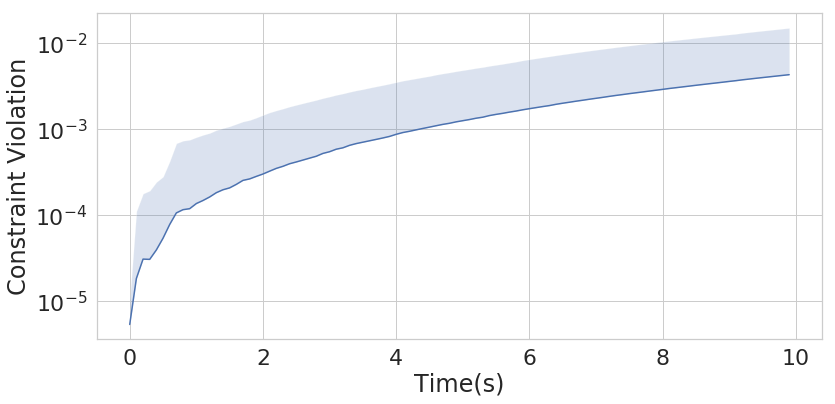

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2.)
sns.set_style('whitegrid')
figsize = (13, 6)
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
sns.set_palette(sns.color_palette("Set1", n_colors=6, desat=.67))
plt.plot(T,mse.mean(0))
plt.fill_between(T,mean+std,mean,alpha=.2)
plt.yscale('log')
plt.xlabel('Time(s)')
plt.ylabel('Constraint Violation')

In [ ]:
plt.savefig('dynamics_scaling.pdf')#, dpi=100, facecolor='w', edgecolor='w',
#         orientation='portrait', papertype=None, format=None,
#         transparent=False, bbox_inches=None, pad_inches=0.1,
#         frameon=None, metadata=None)